# Complete Synthetic Classification Simulation
End-to-End Realistic Classification Benchmark
## Objective

Generate a synthetic binary classification dataset that includes:

- Class imbalance (business-realistic)

- MCAR, MAR, and MNAR missingness

- Numeric and categorical outliers

- Ordinal categorical features

- High-cardinality categorical features

- Non-linear feature interactions

- Heteroskedastic noise

- Deliberate data leakage traps

This dataset is intended to support all downstream DS techniques in your repository.

## Imports and Configuration

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Generate Dataset

## Global Parameters

In [2]:
np.random.seed(2010)

N = 10_000


## Core Numeric Features

In [3]:
age = np.random.randint(18, 80, size=N)

income = np.random.lognormal(mean=10.6, sigma=0.75, size=N)

tenure_years = np.random.exponential(scale=5.5, size=N)

avg_monthly_usage = np.random.gamma(shape=2.2, scale=35, size=N)

support_tickets_last_year = np.random.poisson(lam=1.8, size=N)


## Ordinal Categorical Feature

Customer satisfaction (explicit ordinal signal).

In [4]:
satisfaction_level = np.random.choice(
    ["Very Low", "Low", "Medium", "High", "Very High"],
    size=N,
    p=[0.1, 0.2, 0.35, 0.25, 0.1]
)

satisfaction_map = {
    "Very Low": 0,
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Very High": 4
}

satisfaction_ordinal = pd.Series(satisfaction_level).map(satisfaction_map)


## High-Cardinality Categorical Feature

In [5]:
customer_segment = np.random.choice(
    [f"segment_{i}" for i in range(1, 151)],
    size=N
)


150 categories → encoding stress test.

## Low-Cardinality Nominal Feature

In [6]:
region = np.random.choice(
    ["North", "South", "East", "West"],
    size=N,
    p=[0.4, 0.25, 0.2, 0.15]
)


##  Latent Churn Probability (True Signal)

Target: Customer churn (binary)

In [7]:
linear_signal = (
    -0.00004 * income +
    -0.35 * tenure_years +
    0.6 * support_tickets_last_year +
    -0.5 * satisfaction_ordinal +
    0.015 * avg_monthly_usage
)

regional_effect = pd.Series(region).map({
    "North": -0.1,
    "South": 0.05,
    "East": 0.0,
    "West": 0.1
}).values

logit = linear_signal + regional_effect


## Non-Linearity and Noise

In [8]:
non_linear_effect = 0.3 * np.sin(avg_monthly_usage / 40)

noise = np.random.normal(0, 0.4, size=N)

logit = logit + non_linear_effect + noise


## Convert to Probability and Target

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

churn_probability = sigmoid(logit)


Introduce __class imbalance__ (~20–25% churn):

In [10]:
churn = np.random.binomial(1, churn_probability * 0.9)


pd.Series(churn).value_counts(normalize=True)

0    0.8148
1    0.1852
Name: proportion, dtype: float64

# Create DataFrame

In [11]:
df = pd.DataFrame({
    "customer_id": range(1, N + 1),
    "age": age,
    "income": income,
    "tenure_years": tenure_years,
    "avg_monthly_usage": avg_monthly_usage,
    "support_tickets_last_year": support_tickets_last_year,
    "satisfaction_level": satisfaction_level,
    "customer_segment": customer_segment,
    "region": region,
    "churn": churn
})

df.head()


,customer_id,age,income,tenure_years,avg_monthly_usage,support_tickets_last_year,satisfaction_level,customer_segment,region,churn
0,1,18,39466.030623,2.012501,138.021163,1,Medium,segment_18,South,0
1,2,18,58991.061162,9.005550,213.043003,2,Very High,segment_98,West,0
2,3,67,31130.298545,3.633058,68.591582,2,Medium,segment_134,North,0
3,4,64,41826.447805,4.295957,28.790894,1,High,segment_72,North,0
4,5,37,22301.231175,2.549855,100.136569,2,High,segment_147,East,1


## Inject Outliers
###  Numeric Outliers (Top 1%)

In [12]:
outlier_idx = np.random.choice(df.index, size=int(0.01 * N), replace=False)

df.loc[outlier_idx, "avg_monthly_usage"] *= np.random.uniform(4, 7, size=len(outlier_idx))
df.loc[outlier_idx, "income"] *= np.random.uniform(3, 6, size=len(outlier_idx))


## Missingness Injection
### MCAR (Random)

In [13]:
mcar_idx = np.random.choice(df.index, size=int(0.04 * N), replace=False)
df.loc[mcar_idx, "avg_monthly_usage"] = np.nan


### MAR (Depends on tenure)

In [14]:
mar_mask = df["tenure_years"] < df["tenure_years"].quantile(0.2)
df.loc[mar_mask.sample(frac=0.25, random_state=42).index, "satisfaction_level"] = np.nan


### MNAR (Depends on target)

In [15]:
mnar_mask = df["churn"] == 1
df.loc[mnar_mask.sample(frac=0.3, random_state=42).index, "income"] = np.nan


## Leakage-Prone Feature (Deliberate)

___`NOTE:   This feature must not be used in training.`___



In [16]:
df["future_retention_offer"] = (
    churn * 1.0 +
    np.random.normal(0, 0.1, size=N)
)


___`This feature must not be used in training.`___




## Dataset Diagnostics

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                10000 non-null  int64  
 1   age                        10000 non-null  int32  
 2   income                     7000 non-null   float64
 3   tenure_years               10000 non-null  float64
 4   avg_monthly_usage          9600 non-null   float64
 5   support_tickets_last_year  10000 non-null  int32  
 6   satisfaction_level         7500 non-null   object 
 7   customer_segment           10000 non-null  object 
 8   region                     10000 non-null  object 
 9   churn                      10000 non-null  int32  
 10  future_retention_offer     10000 non-null  float64
dtypes: float64(4), int32(3), int64(1), object(3)
memory usage: 742.3+ KB


In [21]:
df.isna().mean().sort_values(ascending=False)

income                       0.30
satisfaction_level           0.25
avg_monthly_usage            0.04
age                          0.00
customer_id                  0.00
tenure_years                 0.00
support_tickets_last_year    0.00
customer_segment             0.00
region                       0.00
churn                        0.00
future_retention_offer       0.00
dtype: float64

In [19]:
df["churn"].value_counts(normalize=True)


churn
0    0.8148
1    0.1852
Name: proportion, dtype: float64

## Save Dataset

In [22]:
df.to_csv(
    "../datasets/synthetic_customer_churn_classification_complete.csv",
    index=False
)


## What This Dataset Includes



| Aspect                       | Included |
| ---------------------------- | -------- |
| Binary classification target | Yes      |
| Class imbalance              | Yes      |
| Ordinal features             | Yes      |
| High cardinality categorical | Yes      |
| MCAR / MAR / MNAR            | Yes      |
| Numeric outliers             | Yes      |
| Non-linear effects           | Yes      |
| Leakage trap                 | Yes      |
| Business realism             | Yes      |


## Intended Downstream Usage

This dataset feeds directly into:

    01_Exploratory_Data_Analysis/

    02_Data_Preprocessing/

    03_Feature_Engineering/

    04_Supervised_Learning/Classification

    06_Model_Evaluation_and_Validation/

    07_Model_Tuning_and_Optimization/

    13_Imbalanced_Learning/

<br><br><br><br><br><br><br><br>


# Preprocessing and Modeling Pipelines
___`Robust, Imbalance-Aware, and Production-Ready`___






## Objective

This pipeline addresses:

- MCAR / MAR / MNAR missingness

- Ordinal, nominal, and high-cardinality categorical variables

- Numeric skewness and outliers

- Class imbalance

- Explicit data leakage prevention

- Non-linear relationships

Design principles:

- Single source of truth (Pipeline)

- Strict leakage control

- Explicit feature contracts

- Imbalance-aware modeling

## Train / Test Split (Leakage Control)

In [23]:
from sklearn.model_selection import train_test_split

TARGET = "churn"
LEAKAGE_FEATURES = ["future_retention_offer", "customer_id"]

X = df.drop(columns=[TARGET] + LEAKAGE_FEATURES)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Why:

- stratify=y preserves class imbalance

- Leakage-prone features are explicitly removed


## Feature Type Contract

In [24]:
numeric_features = [
    "age",
    "income",
    "tenure_years",
    "avg_monthly_usage",
    "support_tickets_last_year"
]

ordinal_features = ["satisfaction_level"]

nominal_low_cardinality = ["region"]

nominal_high_cardinality = ["customer_segment"]


## Preprocessing Pipelines
### Numeric Pipeline

Design rationale:

- __Median imputation__ → robust to skewness and MNAR proxies

- __Log transform__ → stabilizes heavy tails

- __RobustScaler__ → minimizes outlier influence

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", RobustScaler())
])


## Ordinal Encoding Pipeline

Ordinality is __explicitly preserved.__

In [27]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        categories=[["Very Low", "Low", "Medium", "High", "Very High"]]
    ))
])


## Nominal Low-Cardinality Pipeline

In [28]:
from sklearn.preprocessing import OneHotEncoder

nominal_low_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop="first",
        handle_unknown="ignore"
    ))
])


## Nominal High-Cardinality Pipeline

Strategy:

- Frequency-based one-hot encoding

- Avoids dimensional explosion- 

In [29]:
nominal_high_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        min_frequency=0.02,
        handle_unknown="ignore"
    ))
])


## Unified ColumnTransformer

In [30]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("ord", ordinal_pipeline, ordinal_features),
        ("nom_low", nominal_low_pipeline, nominal_low_cardinality),
        ("nom_high", nominal_high_pipeline, nominal_high_cardinality)
    ],
    remainder="drop"
)


This object is now the __authoritative preprocessing contract.__

# Modeling Pipeline (Imbalance-Aware)
## Model Choice

Random Forest with:

- `class_weight="balanced"` for imbalance

- Strong non-linear modeling

- Robustness to noise

In [31]:
from sklearn.ensemble import RandomForestClassifier


## Full Pipeline

In [32]:
classification_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


## Model Training

In [33]:
classification_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'income',
                                                   'tenure_years',
                                                   'avg_monthly_usage',
                                                   'support_tickets_last_year']),
                                                 ('ord',
                                                  Pipeline(st...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['region']),
                                                 ('nom_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 min_frequency=0.02))]),
                                                  ['customer_segment'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=5, n_estimators=400,
                                        n_jobs=-1, random_state=42))])

## Evaluation (Baseline)

In [34]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

y_pred = classification_pipeline.predict(X_test)
y_proba = classification_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.90      0.85      0.88      1630
           1       0.47      0.59      0.52       370

    accuracy                           0.80      2000
   macro avg       0.69      0.72      0.70      2000
weighted avg       0.82      0.80      0.81      2000

ROC AUC: 0.8246592604874813


## Confusion Matrix

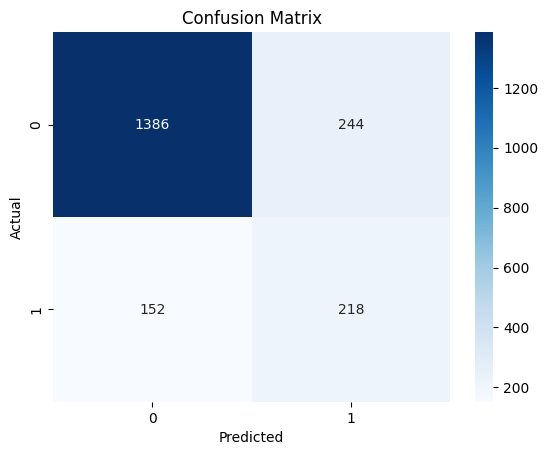

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Why This Pipeline Is Benchmark-Grade

| Dimension                | Covered           |
| ------------------------ | ----------------- |
| Leakage control          | Explicit          |
| Class imbalance          | Class weights     |
| Mixed feature types      | Yes               |
| Ordinality preserved     | Yes               |
| High-cardinality handled | Yes               |
| Missingness              | MCAR / MAR / MNAR |
| Outliers                 | Robust scaling    |
| Reusability              | High              |
| Production readiness     | High              |


# 11. Natural Extensions (Designed In)

This pipeline is intentionally structured to support:

- GridSearchCV / RandomizedSearchCV

- Threshold optimization

- Calibration (CalibratedClassifierCV)

- SHAP / permutation importance

- Serialization and deployment

<br><br><br><br><br><br><br><br>


# Hyperparameter Tuning
## Model Tuning and Optimization
___`GridSearchCV vs RandomizedSearchCV (Classification)`___




Tuning Philosophy (Important)

- __GridSearchCV__

    - Exhaustive

    - Deterministic

    - Best for small, well-understood search spaces

- __RandomizedSearchCV__

    - Stochastic

    - Scales better

    - Preferred for realistic, high-dimensional problems

In production-grade ML:

    RandomizedSearchCV is the default choice

<br><br>

## Cross-Validation Strategy

Because the target is __imbalanced__, we use:

- __StratifiedKFold__

- ROC AUC as the primary metric

In [36]:
from sklearn.model_selection import StratifiedKFold

cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


## Parameter Space Design (Random Forest)

__Note:__ parameters are namespaced through the pipeline

In [37]:
param_distributions = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 8, 12, 18],
    "model__min_samples_leaf": [1, 3, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.7],
    "model__class_weight": ["balanced", "balanced_subsample"]
}


## RandomizedSearchCV (Recommended)
### Setup

In [38]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=classification_pipeline,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    random_state=42
)


### Training

In [39]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\pantu\anaconda3\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('log_transform',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log1p'>)),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['age',
                                                                                'in...
                                                                     min_samples_leaf=5,
                                                                     n_estimators=400,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__class_weight': ['balanced',
                                                                'balanced_subsample'],
                                        'model__max_depth': [None, 8, 12, 18],
                                        'model__max_features': ['sqrt', 'log2',
                                                                0.7],
                                        'model__min_samples_leaf': [1, 3, 5,
                                                                    10],
                                        'model__n_estimators': [200, 400, 600]},
                   random_state=42, scoring='roc_auc', verbose=2)

### Best Model

In [40]:
best_model_random = random_search.best_estimator_


### Evaluation

In [41]:
from sklearn.metrics import roc_auc_score, classification_report

y_pred = best_model_random.predict(X_test)
y_proba = best_model_random.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


ROC AUC: 0.827192837008788
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1630
           1       0.44      0.70      0.54       370

    accuracy                           0.78      2000
   macro avg       0.68      0.75      0.70      2000
weighted avg       0.83      0.78      0.80      2000



## GridSearchCV (Exhaustive Reference)

Use only when the search space is small.

### Reduced Grid

In [42]:
param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 12],
    "model__min_samples_leaf": [3, 5]
}


### Setup

In [43]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=classification_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)


### Training

In [44]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log_transform',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         ['age',
                                                                          'income',...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        min_frequency=0.02))]),
                                                                         ['customer_segment'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               min_samples_leaf=5,
                                                               n_estimators=400,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 12],
                         'model__min_samples_leaf': [3, 5],
                         'model__n_estimators': [300, 500]},
             scoring='roc_auc', verbose=2)

### Best Model

In [45]:
grid_search.best_params_


{'model__max_depth': None,
 'model__min_samples_leaf': 5,
 'model__n_estimators': 300}

In [47]:
best_model_grid = grid_search.best_estimator_


## Model Comparison

In [48]:
print("Random Search ROC AUC:",
      roc_auc_score(y_test, best_model_random.predict_proba(X_test)[:, 1]))

print("Grid Search ROC AUC:",
      roc_auc_score(y_test, best_model_grid.predict_proba(X_test)[:, 1]))


Random Search ROC AUC: 0.827192837008788
Grid Search ROC AUC: 0.8250472558448018


## Why This Design Is Correct



| Aspect             | Best Practice          |
| ------------------ | ---------------------- |
| Leakage-safe       | Pipeline encapsulation |
| Imbalance handling | Class weights          |
| CV strategy        | Stratified             |
| Metric             | ROC AUC                |
| Scalability        | RandomizedSearchCV     |
| Reproducibility    | Fixed random_state     |


# Common Mistakes (Avoided Here)

-  X  Tuning on preprocessed data

-  X  Using accuracy for imbalanced targets

-  X  Not stratifying folds

-  X  Tuning leakage features

-  X  Overly large grids